---
# Sequence to Sequence (Seq2Seq) Models

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import re
import nltk
nltk.download('punkt')
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import copy
torch.set_num_threads(4)
torch.set_num_interop_threads(4)

[nltk_data] Downloading package punkt to /Users/jacob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading Data 

This is an example of building a torch data loader for a dataset. No code needed here.

The raw data is retrieved from: [Many Things - Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

We have already built a small subset of training, validation, and test data for this homework.

We don't necessarily need dataloader for test/validation set in this homework since we won't use the validation dataset to select the model, but feel free to tune the model using the validation dataset.

We will decode sentences in the test dataset one by one for simplicity.

In [2]:
train_csv=pd.read_csv('assets/fr_en/train.csv')
val_csv=pd.read_csv('assets/fr_en/val.csv')
test_csv=pd.read_csv('assets/fr_en/test.csv')

In [3]:
src_vocab,tgt_vocab={},{}

In [4]:
src_tokens=nltk.word_tokenize(' '.join(list(train_csv.en)))
src_counters=Counter(src_tokens)
src_vocab['token_freqs']=src_counters
src_vocab['idx_to_token']=['<unk>','<pad>','<bos>','<eos>']+list(Counter(src_tokens).keys())
token_to_idx={}
for idx,token in enumerate(src_vocab['idx_to_token']):
    token_to_idx[token]=idx
src_vocab['token_to_idx']=token_to_idx
src_vocab['bos']='<bos>'
src_vocab['pad']='<pad>'
src_vocab['unk']='<unk>'
src_vocab['eos']='<eos>'

In [5]:
tgt_tokens=nltk.word_tokenize(' '.join(list(train_csv.fr)))
tgt_counters=Counter(tgt_tokens)
tgt_vocab['token_freqs']=tgt_counters
tgt_vocab['idx_to_token']=['<unk>','<pad>','<bos>','<eos>']+list(Counter(tgt_tokens).keys())
token_to_idx={}
for idx,token in enumerate(tgt_vocab['idx_to_token']):
    token_to_idx[token]=idx
tgt_vocab['token_to_idx']=token_to_idx
tgt_vocab['bos']='<bos>'
tgt_vocab['pad']='<pad>'
tgt_vocab['unk']='<unk>'
tgt_vocab['eos']='<eos>'

In [6]:
class NMTDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, dataframe, src_vocab, tgt_vocab,max_len=10):
        """Method to initilaize variables."""
        self.dataframe = dataframe
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len
        

    def __getitem__(self, index):
        src_tensor = torch.full((self.max_len,),self.src_vocab['token_to_idx'][self.src_vocab['pad']])
        src = self.dataframe.en[index].lower()
        src_tokens = [src_vocab['bos']] + nltk.word_tokenize(src)
        for i in range(min(self.max_len-1,len(src_tokens))):
            src_tensor[i] = self.src_vocab['token_to_idx'][src_tokens[i]] if src_tokens[i] in self.src_vocab['token_to_idx'] \
                                                                        else self.src_vocab['token_to_idx'][self.src_vocab['unk']] 
        src_tensor[i+1]=self.src_vocab['token_to_idx'][self.src_vocab['eos']]
        
        tgt_tensor = torch.full((self.max_len,),self.tgt_vocab['token_to_idx'][self.tgt_vocab['pad']])
        tgt = self.dataframe.fr[index].lower()
        tgt_tokens = [tgt_vocab['bos']] + nltk.word_tokenize(tgt)
        for i in range(min(self.max_len-1,len(tgt_tokens))):
            tgt_tensor[i] = self.tgt_vocab['token_to_idx'][tgt_tokens[i]] if tgt_tokens[i] in self.tgt_vocab['token_to_idx'] \
                                                                        else self.tgt_vocab['token_to_idx'][self.tgt_vocab['unk']] 
        tgt_tensor[i+1]=self.tgt_vocab['token_to_idx'][self.tgt_vocab['eos']]

        return src_tensor, tgt_tensor

    def __len__(self):
        return len(self.dataframe)

In [7]:
batch_size=64
max_len=10

train_set = NMTDataset(train_csv,src_vocab,tgt_vocab,max_len)
# val_set = NMTDataset(val_csv,src_vocab,tgt_vocab,max_len)
# test_set = NMTDataset(test_csv,src_vocab,tgt_vocab,max_len)

train_loader = DataLoader(train_set, batch_size=batch_size)
# val_loader = DataLoader(val_set, batch_size=batch_size)
# test_loader = DataLoader(test_set, batch_size=batch_size)

In [8]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

# Build the encoder

In this question, you will build a GRU encoder.

An encoder should include an embedding layer and a RNN layer.

The input to the model initialization should include the input dimension (source vocabulary size), the embedding dimension (which should also be the input dimension of the GRU layer), the hidden dimension of GRU, the number of layers of GRU, and dropout rate.

In [9]:
class encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout,**kwargs):
        super(encoder,self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        ## TODO: implement embedding layer, GRU and dropout
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        return
        
    def forward(self, src):
        
        ## TODO: feed the input to the encoder network
        # YOUR CODE HERE
        # raise NotImplementedError()
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

# Build the decoder

In this part, you will build a GRU decoder.

The decoder should include an embedding layer, a RNN layer, and a linear layer.

The input to the model initialization should include the output dimension (target vocabulary size), the embedding dimension (which should also be the input dimension of the GRU layer), the hidden dimension of GRU, the number of layers of GRU, and dropout rate.

In [10]:
class decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout,**kwargs):
        super(decoder,self).__init__(**kwargs)

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        ## TODO: implement embedding layer, GRU, linear layer and dropout
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        return
        
    def forward(self, input, hidden):
        
        ## TODO: feed the input to the decoder network
        # YOUR CODE HERE
        # raise NotImplementedError()
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.out(output.squeeze(0))
        return prediction, hidden


# Putting together the seq2seq model 

In this part, you will combine the encoder and decoder to build the seq2seq model.

The seq2seq function below should include an encoder and a decoder. We also initialize a "device" in the code so that you can try the code on a GPU device.

During the forward pass over the network in the "forward" function, please apply a "teacher forcing strategy." It means that at each time step of decoding, the decoder will receive the ground truth token (instead of the predicted token) of that time step. Otherwise, one could also feed the output from the previous step. Teacher forcing helps stabilize model training by preventing error propagation from the previous training steps. But higher teacher forcing can also harm the model performance since the `teacher` could help too much. Hence, we define a hyperparameter that controls the teacher forcing ratio.

In [11]:
class seq2seq(nn.Module):
    def __init__(self, encoder, decoder, device,**kwargs):
        super(seq2seq,self).__init__(**kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        # make sure your dimension is correct
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        # Get hidden state from encoder 
        _, hidden = self.encoder(src)
        
        # First input to the decoder is the <bos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
            
        return outputs

In [12]:
# Hidden tests in this cell

# Initialize the model

In [13]:
random_seed = 3407
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
enc=encoder(len(src_vocab['idx_to_token']),embed_size,num_hiddens,num_layers,dropout)
dec=decoder(len(tgt_vocab['idx_to_token']),embed_size,num_hiddens,num_layers,dropout)
model=seq2seq(enc,dec,None)

In [15]:
# Initialize the parameters
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
model.apply(init_weights)

seq2seq(
  (encoder): encoder(
    (embedding): Embedding(1051, 32)
    (rnn): GRU(32, 32, num_layers=2, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): decoder(
    (embedding): Embedding(2064, 32)
    (rnn): GRU(32, 32, num_layers=2, dropout=0.1)
    (out): Linear(in_features=32, out_features=2064, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)
# Ignore padding tokens when calculating the loss
criterion = nn.CrossEntropyLoss(ignore_index = tgt_vocab['token_to_idx'][tgt_vocab['pad']])
# Clip the gradient to avoid gradient explosion
clip=1
teacher_forcing=0.25

In [17]:
# Decoding outputs to real words function
def decode_output(model,src_sent,src_vocab,tgt_vocab):
    model.eval()
    src_tensor = torch.full((10,),src_vocab['token_to_idx'][src_vocab['pad']])
    src_tokens = [src_vocab['bos']] + nltk.word_tokenize(src_sent)
    for i in range(min(9,len(src_tokens))):
        src_tensor[i] = src_vocab['token_to_idx'][src_tokens[i]] if src_tokens[i] in src_vocab['token_to_idx'] \
                                                                    else src_vocab['token_to_idx'][src_vocab['unk']] 
    src_tensor[i+1]=src_vocab['token_to_idx'][src_vocab['eos']]
    src_tensor=src_tensor.unsqueeze(1)
    Y=torch.zeros(10,1).long()
    Y[0][0]=tgt_vocab['token_to_idx'][tgt_vocab['bos']]
    output=model(src_tensor,Y,0).squeeze().argmax(dim=1).tolist()
    trg_sentence=''
    for idx in output:
        if idx==tgt_vocab['token_to_idx']['<eos>']:
            break
        trg_sentence+=tgt_vocab['idx_to_token'][idx]+' '
    return trg_sentence

In [18]:
# Calculating BLEU score
def bleu(pred_seq, label_seq, k):
    pred_tokens, label_tokens = nltk.word_tokenize(pred_seq), nltk.word_tokenize(label_seq)
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [19]:
# Evaluate the model's performance
def eval_model(model,data_csv,src_vocab,tgt_vocab):
    model.eval()
    bleu_acc=0
    for i in range(len(data_csv)):
        src_sent = data_csv.iloc[i].en
        label_seq = data_csv.iloc[i].fr
        pred_seq = decode_output(model, src_sent, src_vocab, tgt_vocab)
        bleu_acc += bleu(pred_seq, label_seq, 2)
    return bleu_acc / len(data_csv) 

# Clip the gradient 

Recall that the gradient of a RNN model can explode during model training.

So, in this question, you will clip the gradient. 

Hint: It should be one line of code.

Your final model BLEU score should be greater than 0.2 in order to get full credit for this homework. Code that is syntactically correct but that has a lower accuracy will lose half credit. 

In [20]:
epoch=500
loss_list=[]
current_best=0
best_model=0
for i in tqdm(range(epoch)):
    total_loss=0
    model.train()
    for batch in train_loader:
        X, Y= [x.to(device) for x in batch]
        # Transpose the data if you RNN above is not batch first
        X=X.transpose(0,1)
        Y=Y.transpose(0,1)
        
        optimizer.zero_grad()
        output=model(X,Y,teacher_forcing)
        
        # Remove the <bos> in the target sentence to calculate the loss
        tgt_Y=torch.cat((Y[1:,:],torch.full((1,Y.shape[1]),tgt_vocab['token_to_idx'][tgt_vocab['pad']])),dim=0)
        output = output.reshape(-1, output.shape[-1])
        tgt_Y= tgt_Y.reshape(-1)
        loss = criterion(output, tgt_Y)
        loss.backward()
        
        # TODO: Clip the gradient
        # YOUR CODE HERE
        # raise NotImplementedError()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        total_loss+=loss.item()
        
    # Check the model performance every 50 epochs
    if (i+1)%50 == 0:
        val_bleu=eval_model(model,val_csv,src_vocab,tgt_vocab)
        if val_bleu > current_best:
            test_bleu=eval_model(model,test_csv,src_vocab,tgt_vocab)
            print("Current best model, Test BLEU:", test_bleu)
            current_best=val_bleu
            best_model=copy.deepcopy(model)
    loss_list.append(total_loss/len(train_loader))
    

  0%|          | 0/500 [00:00<?, ?it/s]

 10%|█         | 50/500 [01:58<33:36,  4.48s/it]

Current best model, Test BLEU: 0.034536719043872226


 20%|██        | 100/500 [03:57<30:13,  4.53s/it]

Current best model, Test BLEU: 0.059180967590323465


 30%|███       | 150/500 [05:56<26:29,  4.54s/it]

Current best model, Test BLEU: 0.07564165482055715


 40%|████      | 200/500 [07:57<22:38,  4.53s/it]

Current best model, Test BLEU: 0.0788815972203426


 70%|███████   | 350/500 [13:40<11:12,  4.48s/it]

Current best model, Test BLEU: 0.08460945938488826


 80%|████████  | 400/500 [15:36<07:27,  4.48s/it]

Current best model, Test BLEU: 0.08470036210773021


 90%|█████████ | 450/500 [17:32<03:38,  4.37s/it]

Current best model, Test BLEU: 0.08794118488215184


100%|██████████| 500/500 [19:25<00:00,  2.33s/it]

Current best model, Test BLEU: 0.09243702733573947


In [21]:
# You should have at least 0.2 BELU
# Hidden tests in this cell

In [22]:
# You should have at least 0.2 BELU
# Hidden tests in this cell

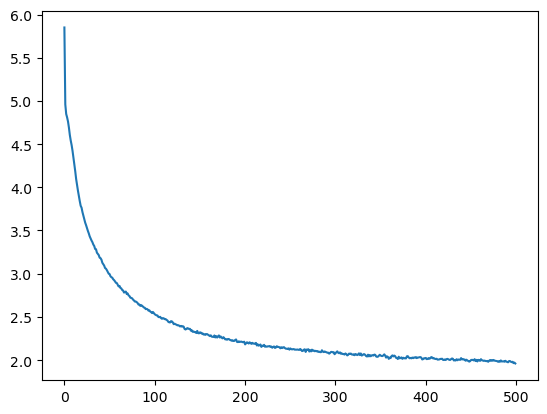

In [23]:
# Plot the loss change over epochs
plt.plot(loss_list)

In [24]:
# Hidden tests in this cell
# loss should decreasing every 50 epochs